<a href="https://colab.research.google.com/github/khoatna065/ML_Churned_Users_Prediction/blob/main/Tran_Nu_Anh_Khoa_ML_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# Data loading

In [ ]:
data = pd.read_excel('/content/churn_prediction.xlsx')
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
print(f'Dataset Dimension: {data.shape[0]} rows, {data.shape[1]} columns')

Dataset Dimension: 5630 rows, 20 columns


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

- The variables Tenure, WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder have missing values.

- Data types vary across column including int, float and object.

# Data processing

## Check imbalanced data

<Axes: xlabel='Churn', ylabel='count'>

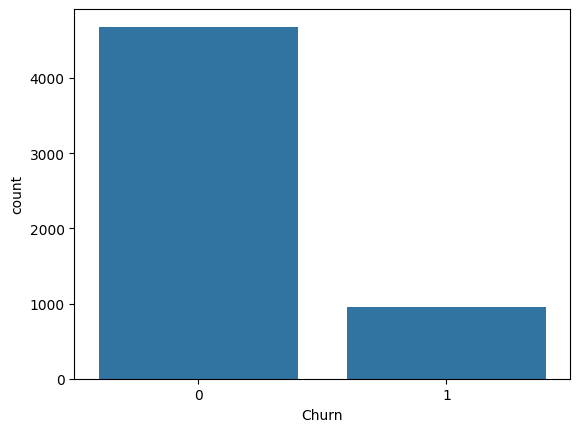

In [ ]:
churn = data['Churn'].value_counts().reset_index()
sns.barplot(x='Churn', y='count', data=churn)

In [ ]:
neg, pos = np.bincount(data['Churn'])
total = neg + pos
print(' Total: {}\n Churned: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

 Total: 5630
 Churned: 948 (16.84% of total)



-- Quite imbalanced so still process ML model as normal.

## Data wrangling

### Duplicated values

In [ ]:
data.nunique()

CustomerID                     5630
Churn                             2
Tenure                           36
PreferredLoginDevice              3
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              7
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  15
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2586
dtype: int64

In [ ]:
data.duplicated().sum()

0

-- No duplicated values found

### Missing values

In [ ]:
data.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

-- The variables have missing values: Tenure, WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder.

- Tenure refers to the length of time a customer in organization. Missing values should be replaced with 0.
- WarehouseToHome is the distance in between warehouse to home of customer. Missing values should be replace with median.
- HourSpendOnApp is the number of hours spend on mobile application or website. Missing values should be replaced with 0.
- OrderAmountHikeFromlastYear is percentage increases in order from last year. Missing values should be replaced with 0.
- CouponUsed is total number of coupon has been used in last month. Missing values should be replaced with 0.
- OrderCount is total number of orders has been places in last month. Missing values should be replaced with median.
- DaySinceLastOrder is the day since last order by customer. Missing values should be replaced with median.

In [ ]:
#handle missing values
data['Tenure'].fillna(0, inplace=True)
data['WarehouseToHome'].fillna(data['WarehouseToHome'].median(), inplace=True)
data['HourSpendOnApp'].fillna(0, inplace=True)
data['OrderAmountHikeFromlastYear'].fillna(0, inplace=True)
data['CouponUsed'].fillna(0, inplace=True)
data['OrderCount'].fillna(data['OrderCount'].median(), inplace=True)
data['DaySinceLastOrder'].fillna(data['DaySinceLastOrder'].median(), inplace=True)

### Change data type

In [ ]:
#covert customerID to object
data['CustomerID']= data['CustomerID'].astype('object')

## Descriptive Summary

Numeric features

In [ ]:
num_cols = data.select_dtypes(include=['float64', 'int64'])
print('There are {} numerical variables\n'.format(len(list(num_cols.columns.values))))
print('The numerical variables are: ', num_cols.columns)

There are 14 numerical variables

The numerical variables are:  Index(['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')


Category features

In [ ]:
cat_cols = data.select_dtypes(include = ['object']).drop(columns=['CustomerID'])
print('There are {} categorical variables\n'.format(len(list(cat_cols.columns.values))))
print('The cateforical variables are: ', cat_cols.columns)

There are 5 categorical variables

The cateforical variables are:  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')


In [ ]:
round(num_cols.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
Churn,5630.0,0.17,0.37,0.0,0.00,0.00,0.00,1.00
Tenure,5630.0,9.71,8.63,0.0,1.00,8.00,15.00,61.00
CityTier,5630.0,1.65,0.92,1.0,1.00,1.00,3.00,3.00
WarehouseToHome,5630.0,15.57,8.35,5.0,9.00,14.00,20.00,127.00
HourSpendOnApp,5630.0,2.80,0.93,0.0,2.00,3.00,3.00,5.00
NumberOfDeviceRegistered,5630.0,3.69,1.02,1.0,3.00,4.00,4.00,6.00
SatisfactionScore,5630.0,3.07,1.38,1.0,2.00,3.00,4.00,5.00
NumberOfAddress,5630.0,4.21,2.58,1.0,2.00,3.00,6.00,22.00
Complain,5630.0,0.28,0.45,0.0,0.00,0.00,1.00,1.00
OrderAmountHikeFromlastYear,5630.0,14.97,4.89,0.0,13.00,14.00,18.00,26.00


In [ ]:
cat_cols.describe().T

,count,unique,top,freq
PreferredLoginDevice,5630,3,Mobile Phone,2765
PreferredPaymentMode,5630,7,Debit Card,2314
Gender,5630,2,Male,3384
PreferedOrderCat,5630,6,Laptop & Accessory,2050
MaritalStatus,5630,3,Married,2986


## EDA

**The patterns of churned users:**
- New customer are more likely to churn.
- Customers with complain are more likely to churn. Some churned customers have satisfaction score higher than customers who don't.
- Customers who registered on more than 3 deviced are more likely to churn.
- Major customers who moved out have COD as Payment method. Customers who opted Credit-Card and Debit-Card or Cash on Delivery as payment method were less likely to move out.
- There is negligible difference in customer count who churned, both gender behaved in similar fashion. Customers single have higher chances of churning as compared to customers who divorced and married.
- Customers preferred order mobile and mobile phone category are much more likely to churn then grocery and others.

**Suggestion to the company to reduce churned users:** Customer churn is definitely bad to a firm's profitability. Various strategies can be implemented to eliminate customer churn. The best way to avoid customer churn is for a company to truly know its customers. This includes identifying customers who are at risk of churning and working to improve their satisfaction. Improving customer service is, of course, at the top of the priority for tackling this issue. Building customer loyalty through relevant experiences and specialized service is another strategy to reduce customer churn. Some firms survey customers who have already churned to understand their reasons for leaving in order to adopt a proactive approach to avoiding future customer churn.


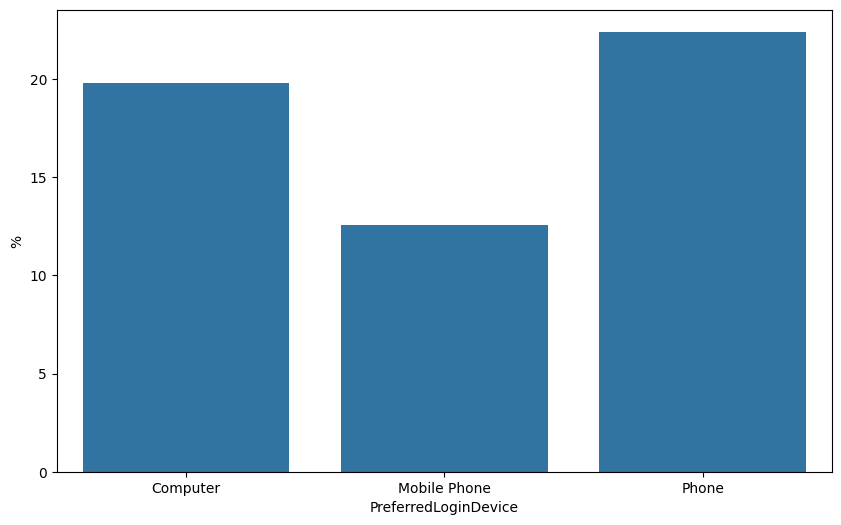

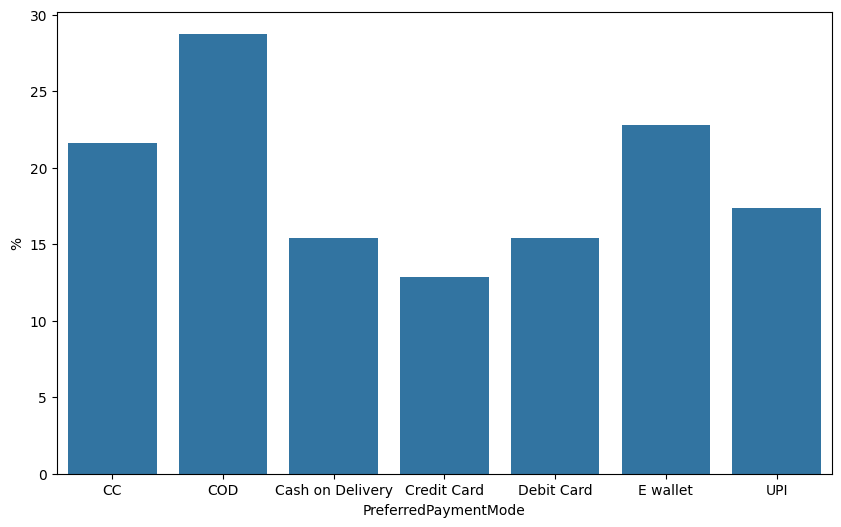

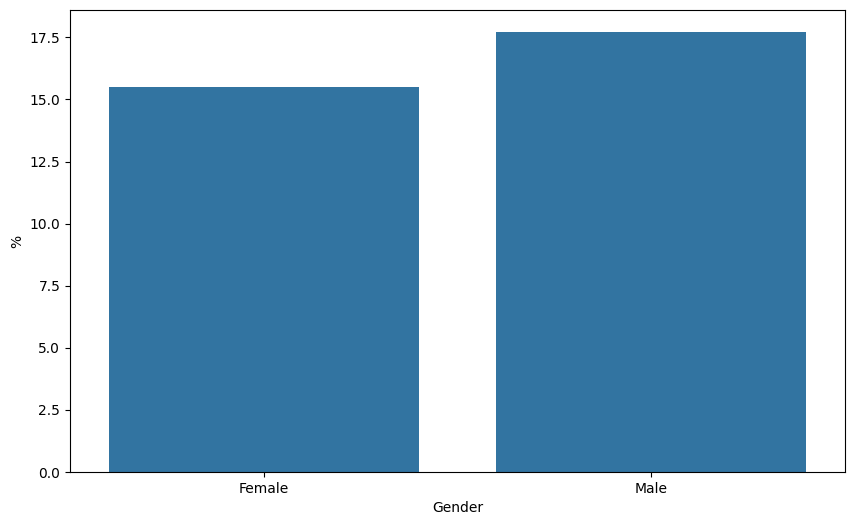

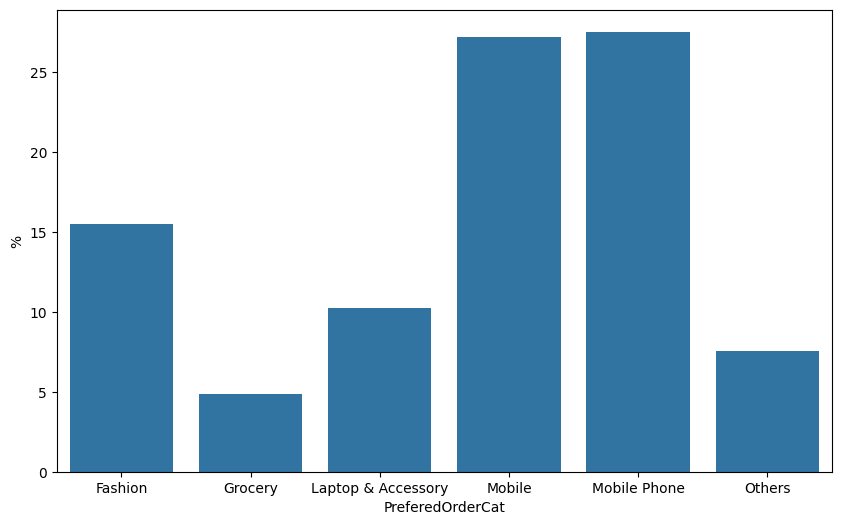

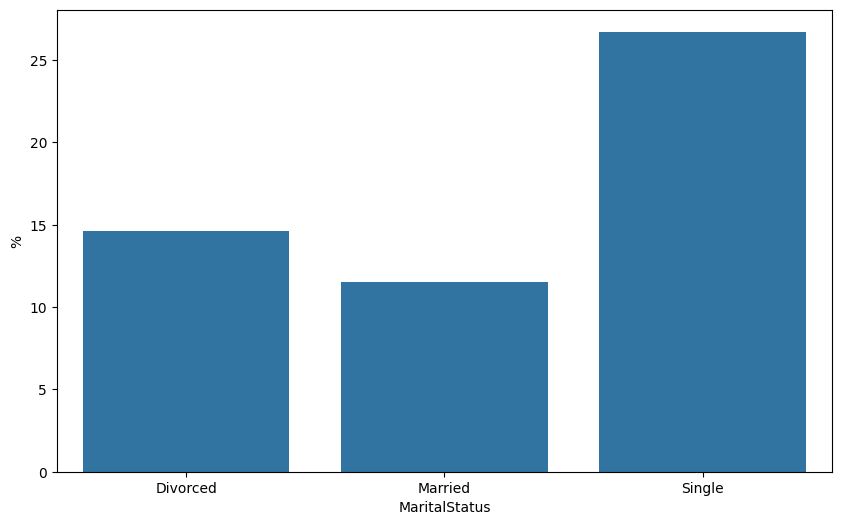

In [ ]:
#category: check percentage of churn over total
def cate_visualize(cate_column):

    '''
    This function to plot the barchart of percentage of churn users over total users per values in category columns
    Input:
    - the category column need to be groupby
    Output:
    - the barchart that present % of churned users groupby values in column
    '''
    total_df = data.groupby(cate_column)[['CustomerID']].nunique().reset_index()
    plot_df = data[data['Churn']==1].groupby(cate_column)[['CustomerID']].nunique().reset_index()
    merge_df = pd.merge(total_df, plot_df, on = cate_column)
    merge_df['%'] = plot_df['CustomerID']/sum(plot_df['CustomerID'])
    merge_df.rename(columns = {'CustomerID_x':'Total_users','CustomerID_y':'Churn_users'}, inplace=True)
    merge_df['%'] = (merge_df['Churn_users']/merge_df['Total_users'])*100
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=merge_df, x=cate_column,y='%', ax=ax)

for x in cat_cols:
  cate_visualize(x)

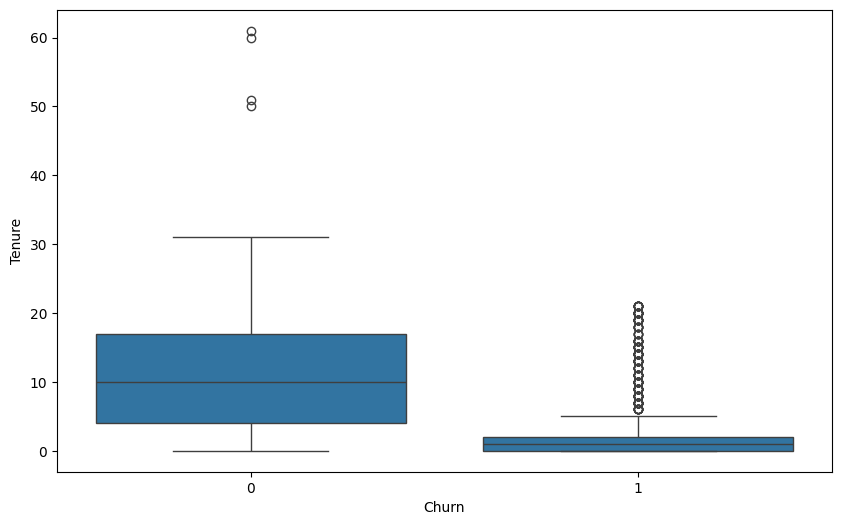

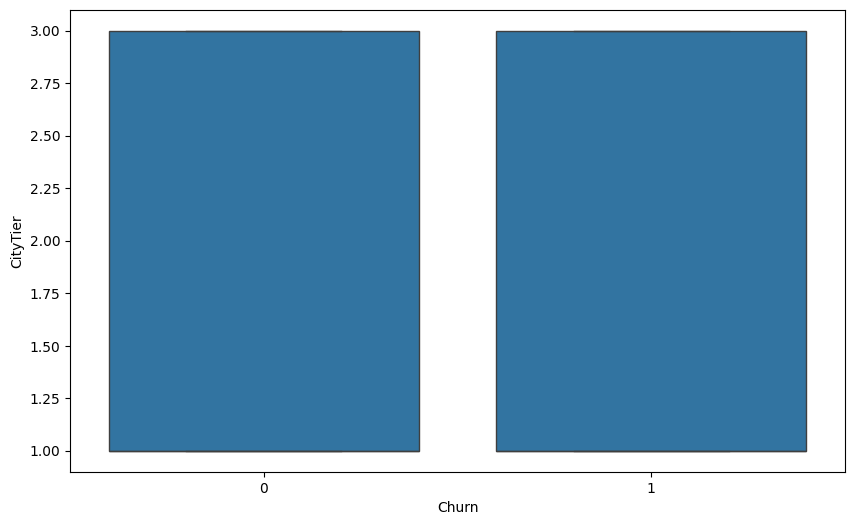

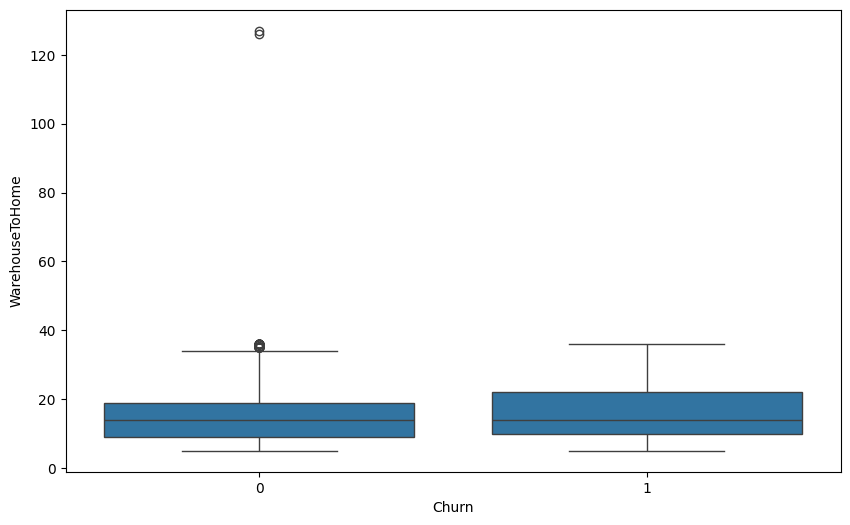

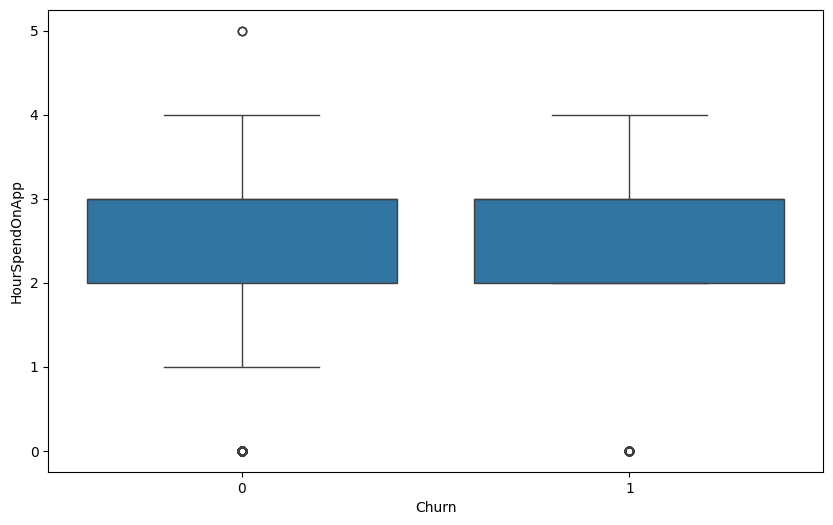

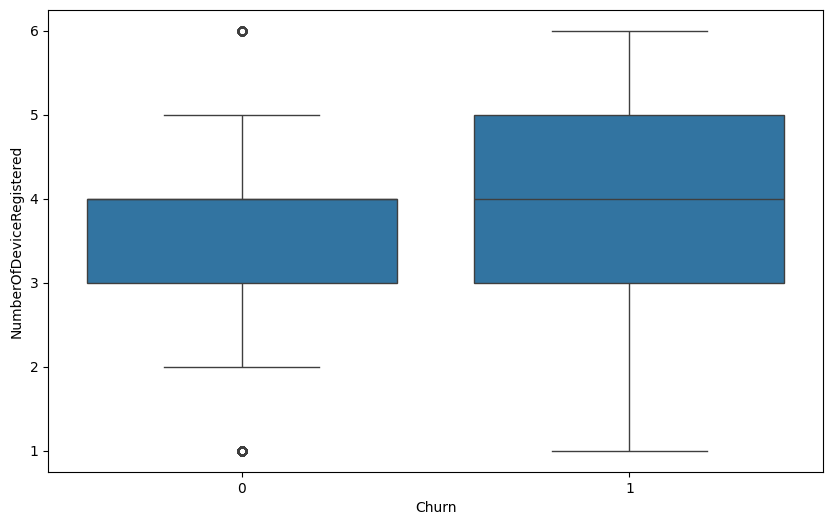

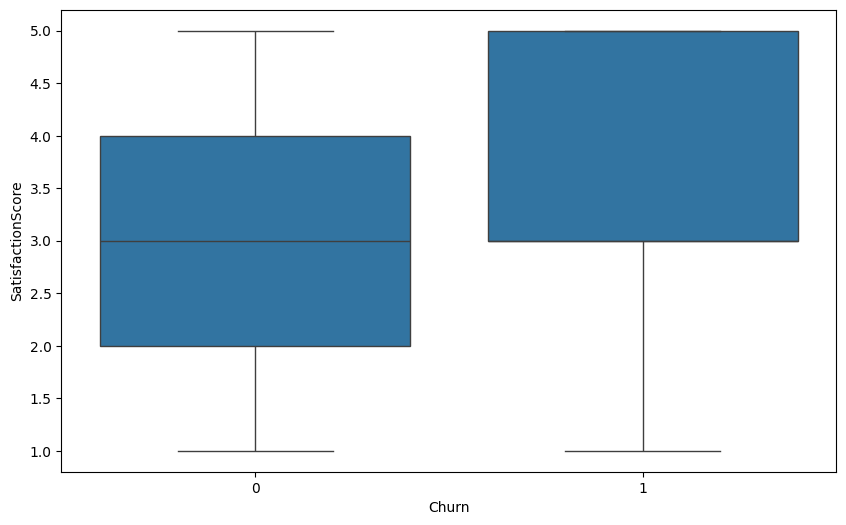

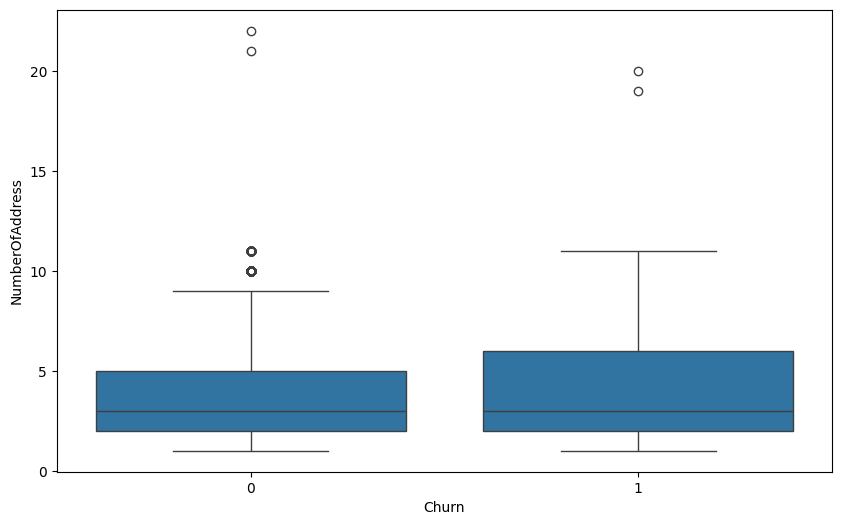

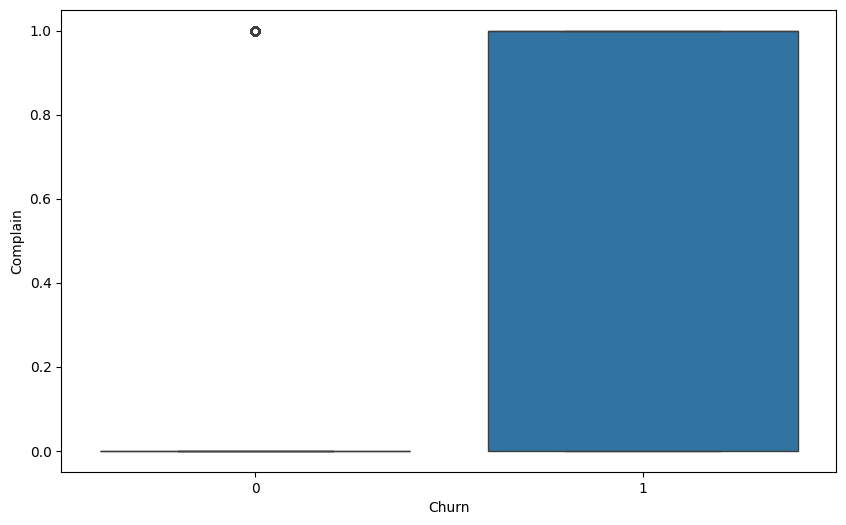

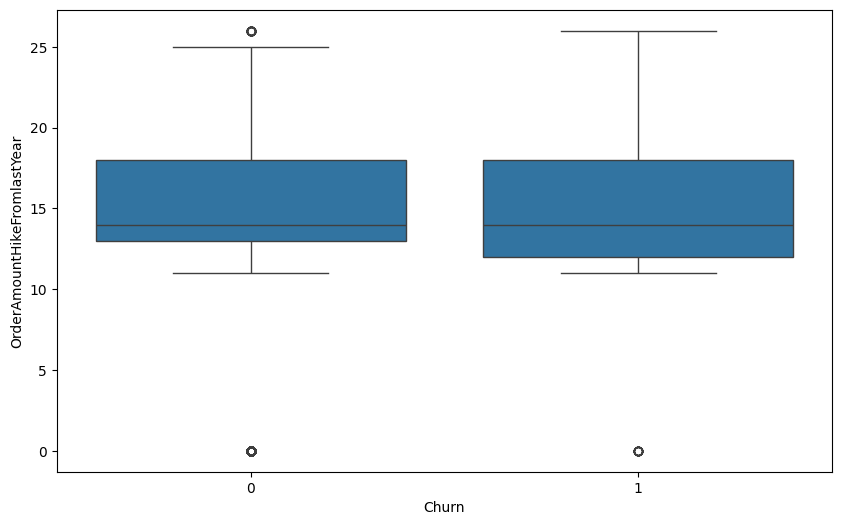

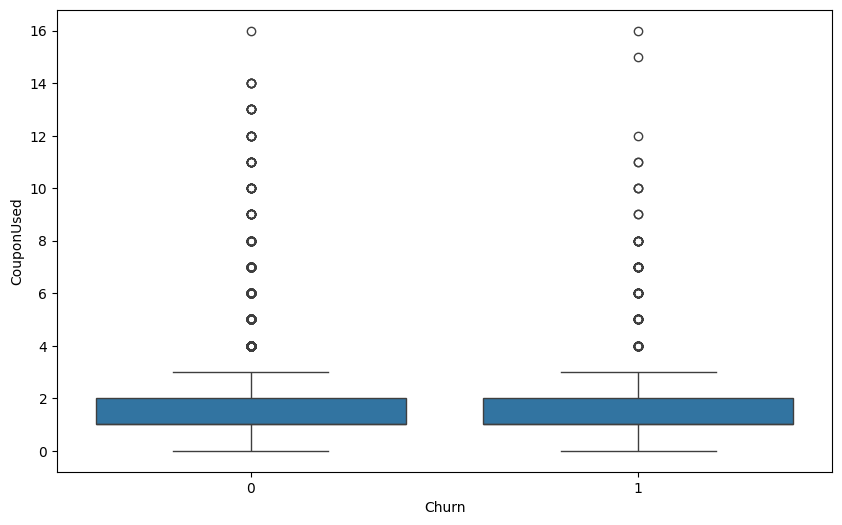

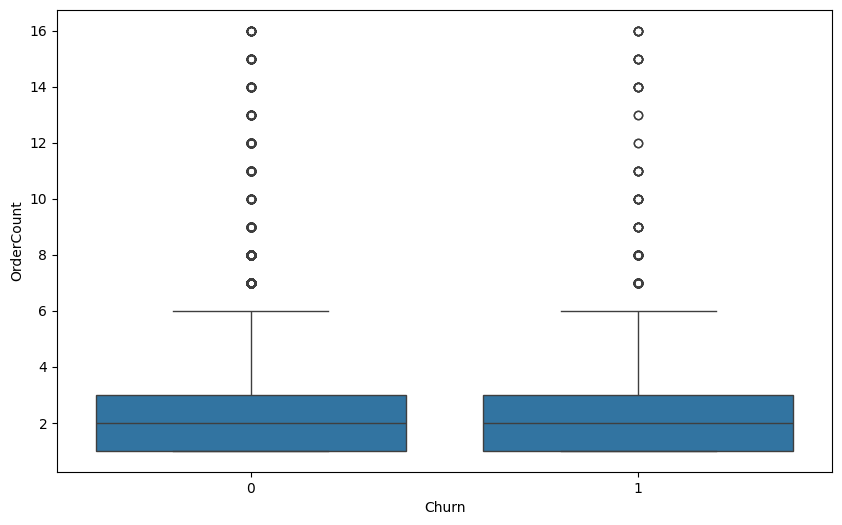

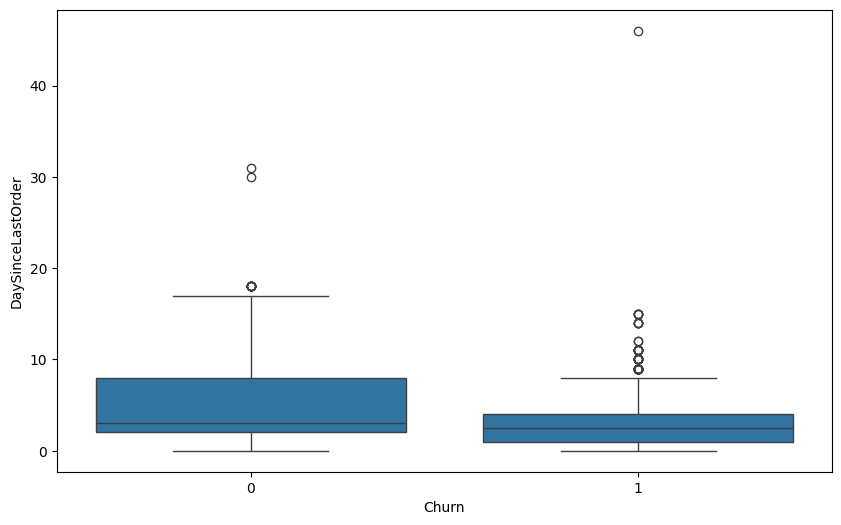

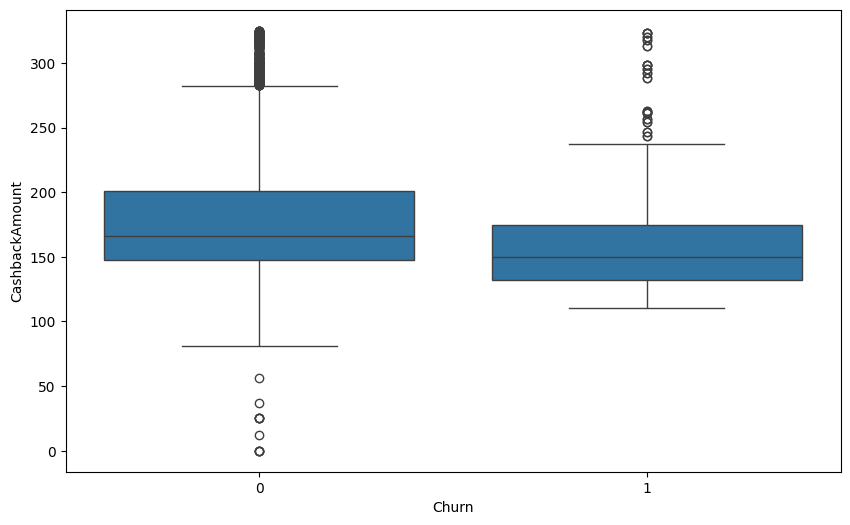

In [ ]:
#Numerical check correlation
def numeric_visualize(numeric_column):

    '''This function plot the boxplot of numeric columns in churn or not churn users'''

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=data, x='Churn',y=numeric_column)

for x in num_cols.drop(columns=['Churn']):
  numeric_visualize(x)

Correlation:
- OrderCount has a strong positive correlation to CouponUsed 0.62. Customer who has placed more order will tend to use more coupon.  
- CashbackAmount has a negative correlation with OrderAmountHikeFromlastYear. The more the refund amount, the lower percentage increases in order.
- Days Since Last Order: The time elapsed since a customer's last order (DaySinceLastOrder) has a weak connection with the quantity of items ordered (OrderCount). Customers who order more frequently may tend to buy smaller quantities, but this relationship isn't very strong.

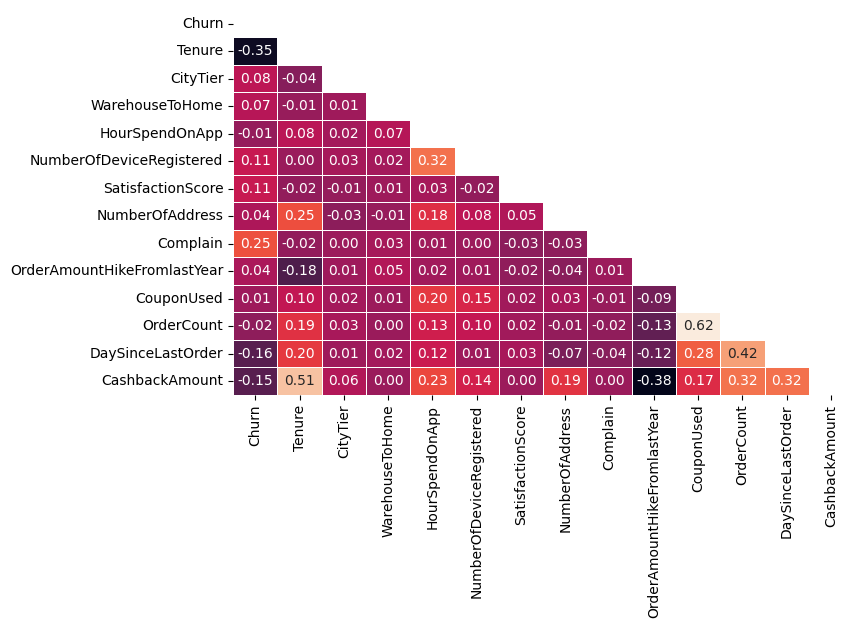

In [ ]:
corr = num_cols.corr(method='pearson')
mask = np.triu(np.ones_like(corr))
fig = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True,fmt='.2f',mask=mask, cbar=None, linewidth=0.5)
plt.show()


#Feature transforming

## Encoding

In [ ]:
#transform categorical features to binary features
dummies = pd.get_dummies(cat_cols, dtype=int)
data = pd.concat([num_cols, dummies], axis=1)
data

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,0,0,0,1,0,0,0,0,0,1
1,1,0.0,1,8.0,3.0,4,3,7,1,15.0,...,1,0,0,0,1,0,0,0,0,1
2,1,0.0,1,30.0,2.0,4,3,6,1,14.0,...,1,0,0,0,1,0,0,0,0,1
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,1,0,0,1,0,0,0,0,0,1
4,1,0.0,1,12.0,0.0,3,5,3,0,11.0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,1,30.0,3.0,2,1,6,0,18.0,...,1,0,0,1,0,0,0,0,1,0
5626,0,13.0,1,13.0,3.0,5,5,6,0,16.0,...,1,1,0,0,0,0,0,0,1,0
5627,0,1.0,1,11.0,3.0,2,4,3,1,21.0,...,1,0,0,1,0,0,0,0,1,0
5628,0,23.0,3,9.0,4.0,5,4,4,0,15.0,...,1,0,0,1,0,0,0,0,1,0


## Normalization

In [ ]:
#transform all feature to the same range
scaler = MinMaxScaler()
scaler.fit(data)

scaled_data = scaler.transform(data)

data = pd.DataFrame(scaled_data, columns=data.columns)
data

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,0.423077,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.000000,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,0.576923,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.000000,0.0,0.204918,0.4,0.6,0.50,0.238095,1.0,0.538462,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.000000,1.0,0.081967,0.4,0.6,1.00,0.333333,0.0,0.884615,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.000000,0.0,0.057377,0.0,0.4,1.00,0.095238,0.0,0.423077,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0.0,0.163934,0.0,0.204918,0.6,0.2,0.00,0.238095,0.0,0.692308,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5626,0.0,0.213115,0.0,0.065574,0.6,0.8,1.00,0.238095,0.0,0.615385,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5627,0.0,0.016393,0.0,0.049180,0.6,0.2,0.75,0.095238,1.0,0.807692,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5628,0.0,0.377049,1.0,0.032787,0.8,0.8,0.75,0.142857,0.0,0.576923,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model selection

Build 3 Machine Learning Models for predicting churned users.
- Logistic Regression
- Decision Tree
- Random forest

## Split data into separate training and test set

In [ ]:
#Declare feature vector and target variable
X = data.drop(columns=['Churn'], axis=1)
y = data['Churn']

In [ ]:
#Split X and y into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#Check the shape of X_train and X_test
X_train.shape , X_test.shape

((3941, 34), (1689, 34))

## Logistic Regression

In [ ]:
#Train a logistic regression model on the training set
logreg = LogisticRegression()

#fit the model
logreg.fit(X_train, y_train)

#Apply model on train set and test set
y_logreg_pred_train = logreg.predict(X_train)
y_logreg_pred_test = logreg.predict(X_test)

#Calculate the balanced accuracy on train set and test set to check overfitting and underfitting
print(f'Balanced accuracy of train set: {balanced_accuracy_score(y_train, y_logreg_pred_train)}')
print(f'Balanced accuracy of test set: {balanced_accuracy_score(y_test, y_logreg_pred_test)}')

Balanced accuracy of train set: 0.7175690335933479
Balanced accuracy of test set: 0.7235334962067635


## Decision Tree

In [ ]:
# Fit model into train set:
clf_des = tree.DecisionTreeClassifier()
clf_des.fit(X_train, y_train)

# Apply model on train set and test set:
y_tree_pre_train = clf_des.predict(X_train)
y_tree_pre_test = clf_des.predict(X_test)

# Calculate the balanced accuracy on train set and test set to check overfiting and underfiting:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9178757875787579


## Random forest

In [ ]:
# Fit model into train set:
clf_rand = RandomForestClassifier(max_depth=2, random_state=0)
clf_rand.fit(X_train, y_train)

# Apply model on train set and test set:
y_ranf_pre_train = clf_rand.predict(X_train)
y_ranf_pre_test = clf_rand.predict(X_test)

# Calculate the balanced accuracy on train set and test set to check overfiting and underfiting:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_pre_test)}')

Balance accuracy of train set: 0.5
Balance accuracy of test set: 0.5


- Check accuracy score: Decision Tree model has highest balanced accuracy score.
Here, the training set balanced accuracy score is 1.0 while the test set balanced accuracy score is 0.9178. Theses two values are quite comparable. So, there is no sign overfitting


# Feature important

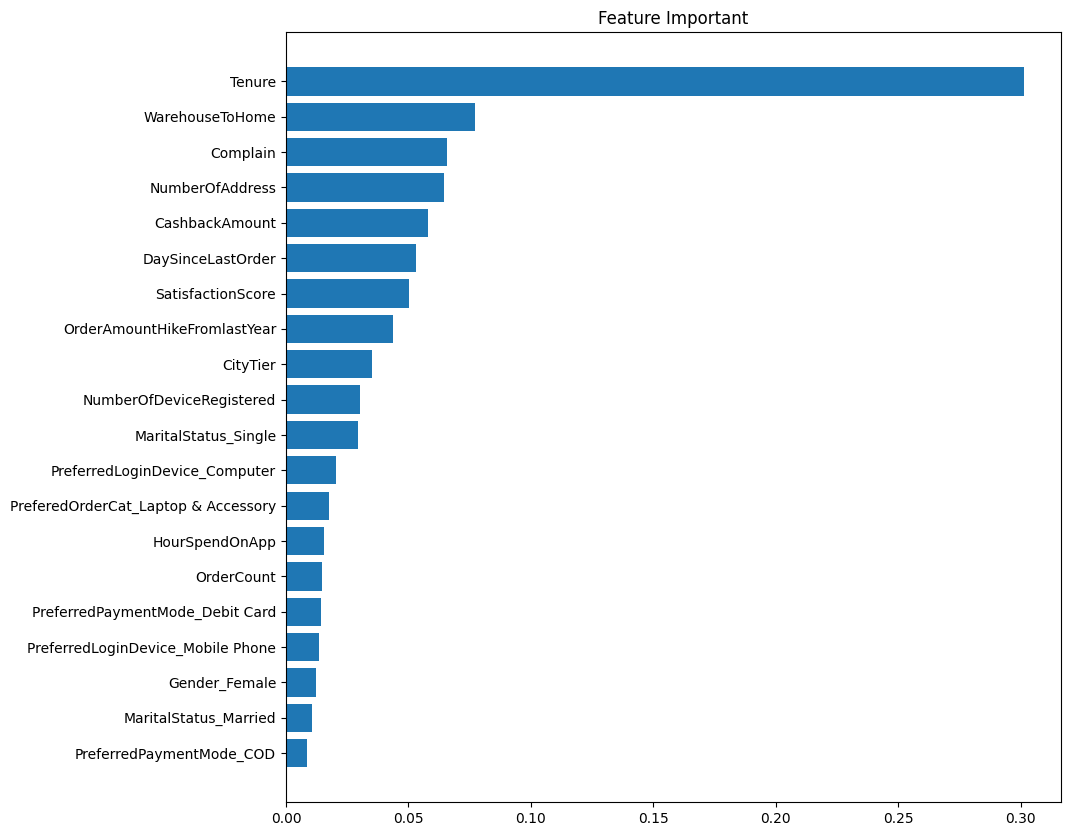

In [ ]:
#show the feature important of decision tree model
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(X_test.columns, clf_des.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

# Confusion matrix

In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_tree_pre_test)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1372   42]
 [  37  238]]


# Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_tree_pre_test))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1414
         1.0       0.85      0.87      0.86       275

    accuracy                           0.95      1689
   macro avg       0.91      0.92      0.91      1689
weighted avg       0.95      0.95      0.95      1689



# Results and conclusion

- In this project, I build three models, Logistic Regression, Decision Tree and Random Forest to predict the churned users . The Decision Tree model is a very good performance by the model balanced accuracy which was found to be 0.9178.

- In the Decision Tree, the training-set balanced accuracy score is 1.0 while the test-set accuracy to be 0.9178. These two values are quite comparable. So, there is no sign of overfitting.

- The confusion matrix and classification report yields very good model performance.

